# Clasificar Texto con Codificador Transformer
Lucía Chicharro, María Montero y Patricia Ramos.

Utilizar un Codificador Transformer para clasificar las noticias de Reuters en 46 temas mutuamente excluyentes. Como cada noticia debe clasificarse en una sola categoría, es un problema de "clasificación multiclase de una sola etiqueta".

El Reuters dataset es un conjunto de noticias breves y sus temas, publicado por Reuters en 1986. Son 46 temas diferentes; algunos temas están más representados que otros, pero cada uno tiene, al menos, 10 ejemplos en el conjunto de entrenamiento.

En primer lugar, leemos los datos.

In [1]:
from keras.datasets import reuters
import numpy as np
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

2110848/2110848 [==============================] - 1s 1us/step


Del total de los datos, el 80% se emplea para entrenar y el 20% restante para las pruebas. Además, creamos un conjunto de validación siendo éste el 20% de los de entrenamiento.

In [3]:
from sklearn.model_selection import train_test_split

# Separar el conjunto de entrenamiento en entrenamiento y validación
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

En este caso, las noticias ya han sido vectorizados de manera que cada palabra es un número representado en el siguiente diccionario.

In [ ]:
reuters.get_word_index()

**Transformer Encoder implementado como una subclase de `Layer`**

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        # Tamaño de los vectores de los tokens de entrada
        self.embed_dim = embed_dim
        # Tamaño de la capa densa interna
        self.dense_dim = dense_dim
        # Número de attention heads
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    # El cálculo va en call()
    def call(self, inputs, mask=None):
        # La máscara que generará la capa Embedding
        # será 2D, pero la capa de atención espera
        # ser 3D o 4D, por lo que ampliamos su rango
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    # Implementamos la serialización para
    # que podamos guardar el modelo
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

Para inyectar información al modelo sobre el orden en el que se encuentran las palabras en el texto, creamos una función que agregue la posición de la palabra en el word-embedding. Por tanto, los word-embedding de entrada tendrán el vector que representa la palabra junto a un vector posición. Para ello, usaremos la técnica de positional embedding.

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class PositionalEmbedding(layers.Layer):
    # Una desventaja de las incrustaciones de posición es que
    # la longitud de la secuencia debe conocerse de antemano
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        # Prepara una capa de embedding para los índices de token.
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            # Y otro para las posiciones te tokens
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        # Agrega ambos vectores embeddings juntos
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        # Al igual que la capa de embedding,
        # esta capa debería poder generar una
        # máscara para que podamos ignorar los
        # ceros de relleno en las entradas.
        # El framework llamará automáticamente
        # al método compute_mask y la máscara
        # se propagará a la siguiente capa.
        return tf.math.not_equal(inputs, 0)

    # Implementamos la serialización para que
    # podamos guardar el modelo.
    def get_config(self):
        config = super().get_config()
        # config = super(PositionalEmbedding, self).get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

Ahora ya podemos usar el Transformer para clasificar el texto.

En este caso, el tamaño del vocabulario son las palabras únicas que contiene. El tamaño de la secuencia es para cada texto, el número de palabras que contiene. Sin embargo, tomaremos como límite el texto que contiene mayor número de palabras. La dimensión del embedding hace referencia a la dimensión del vector que se emplea para representar cada palabra en el espacio vectorial. Además, debemos especificar el número de cabezas que emplearemos de manera que a mayor número más especificaciones puede aprender el modelo. Finalmente, determinamos el tamaño de la capa densa que hace que el modelo verdaderamente aprenda algo.

Al ser un problema de clasificación multiclase debemos realizar algunas modificaciones:


*   La capa de salida debe contener tantas neuronas como clases tengamos, en este caso 46. Además, la fución de ativación deber ser `softmax`
*   Para la función de pérdida se debe emplear `sparse_categorical_crossentropy` o `categorical_crossentropy`



In [8]:
vocab_size = 9976  # palabras unicas del vocabulario (9976)
sequence_length = 2376
embed_dim = 200
num_heads = 3
dense_dim = 32

inputs = keras.Input(shape=(None,), dtype="int64")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(46, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 positional_embedding (Posi  (None, None, 200)         2470400   
 tionalEmbedding)                                                
                                                                 
 transformer_encoder (Trans  (None, None, 200)         495832    
 formerEncoder)                                                  
                                                                 
 global_max_pooling1d (Glob  (None, 200)               0         
 alMaxPooling1D)                                                 
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                             

Dado que cada texto tiene una longitud diferente, debemos rellenar las posiciones faltantes hasta llegar al máximo.

In [9]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_data_padded = pad_sequences(train_data, maxlen=sequence_length, padding='post')
test_data_padded = pad_sequences(test_data, maxlen=sequence_length, padding='post')
val_data_padded = pad_sequences(val_data, maxlen=sequence_length, padding='post')

Creamos una función para pintar la pérdida.

In [10]:
import matplotlib.pyplot as plt

def pinta_perdida_entrenamiento_validacion(historia):
  history_dict = historia.history
  acc = historia.history['accuracy']
  val_acc = historia.history['val_accuracy']
  loss = historia.history['loss']
  val_loss = historia.history['val_loss']
  epochs = range(1, len(acc) + 1)
  # "bo" es para "punto azun"
  plt.plot(epochs, loss, 'bo', label='Pérdida de Entrenamiento')
  # "b" es para "linea continua azul"
  plt.plot(epochs, val_loss, 'b', label='Pérdida de Validación')
  plt.title('Pérdida de Entrenamiento y Validación')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [11]:
callbacks = [
    keras.callbacks.ModelCheckpoint("full_transformer_encoder.keras",
                                    save_best_only=True)
]

Dado que no son demasiados datos, entrenaremos el modelo en primer lugar con 10 épocas.

In [ ]:
hist = model.fit(train_data_padded,train_labels, validation_data=(val_data_padded, val_labels),epochs=10, callbacks=callbacks)
print(f"Test acc: {model.evaluate(test_data_padded,test_labels)[1]:.3f}")

Epoch 1/10
225/225 [==============================] - 184s 791ms/step - loss: 2.1932 - accuracy: 0.5235 - val_loss: 1.3607 - val_accuracy: 0.6806
Epoch 2/10
225/225 [==============================] - 185s 823ms/step - loss: 1.3279 - accuracy: 0.7034 - val_loss: 1.1956 - val_accuracy: 0.7396
Epoch 3/10
225/225 [==============================] - 183s 811ms/step - loss: 1.0093 - accuracy: 0.7652 - val_loss: 0.9667 - val_accuracy: 0.7774
Epoch 4/10
225/225 [==============================] - 185s 823ms/step - loss: 0.8279 - accuracy: 0.8038 - val_loss: 0.8780 - val_accuracy: 0.8047
Epoch 5/10
225/225 [==============================] - 185s 822ms/step - loss: 0.6760 - accuracy: 0.8374 - val_loss: 0.9965 - val_accuracy: 0.7841
Epoch 6/10
225/225 [==============================] - 185s 823ms/step - loss: 0.5641 - accuracy: 0.8639 - val_loss: 0.8736 - val_accuracy: 0.8164
Epoch 7/10
225/225 [==============================] - 182s 810ms/step - loss: 0.4931 - accuracy: 0.8807 - val_loss: 0.8366 -

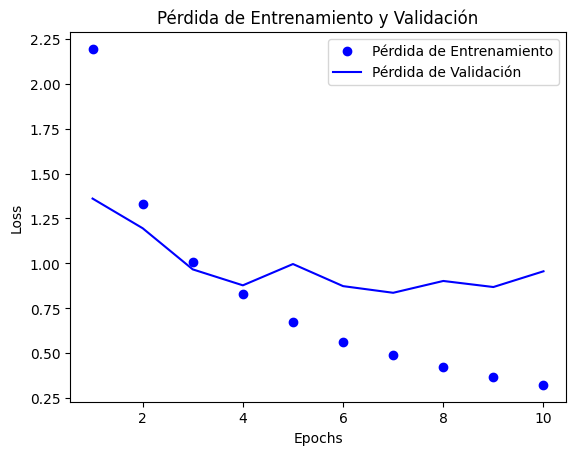

In [ ]:
pinta_perdida_entrenamiento_validacion(hist)

Para este caso, se obtiene una precisión de un 77,1%,  no demasiado buena.

Subamos las épocas a 15.

In [ ]:
hist3 = model.fit(train_data_padded,train_labels, validation_data=(val_data_padded, val_labels),epochs=15, callbacks=callbacks)
print(f"Test acc: {model.evaluate(test_data_padded,test_labels)[1]:.3f}")

Epoch 1/15
225/225 [==============================] - 185s 821ms/step - loss: 0.2991 - accuracy: 0.9264 - val_loss: 0.9931 - val_accuracy: 0.8175
Epoch 2/15
225/225 [==============================] - 181s 807ms/step - loss: 0.2728 - accuracy: 0.9290 - val_loss: 0.9118 - val_accuracy: 0.8275
Epoch 3/15
225/225 [==============================] - 181s 807ms/step - loss: 0.2463 - accuracy: 0.9378 - val_loss: 0.9969 - val_accuracy: 0.8203
Epoch 4/15
225/225 [==============================] - 184s 819ms/step - loss: 0.2223 - accuracy: 0.9438 - val_loss: 0.9570 - val_accuracy: 0.8280
Epoch 5/15
225/225 [==============================] - 184s 820ms/step - loss: 0.2136 - accuracy: 0.9427 - val_loss: 1.0541 - val_accuracy: 0.8275
Epoch 6/15
225/225 [==============================] - 182s 807ms/step - loss: 0.1941 - accuracy: 0.9474 - val_loss: 0.9970 - val_accuracy: 0.8152
Epoch 7/15
225/225 [==============================] - 184s 819ms/step - loss: 0.1823 - accuracy: 0.9478 - val_loss: 0.9937 -

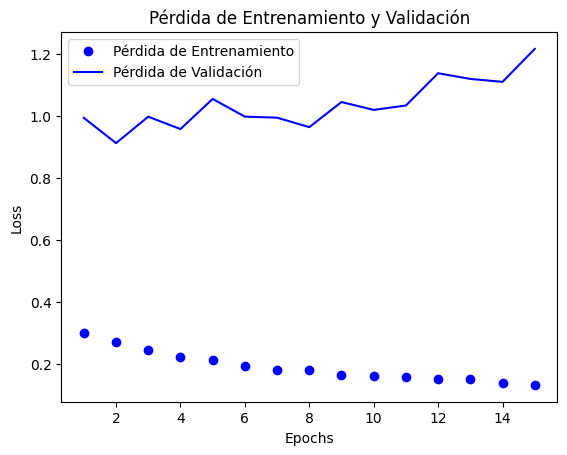

In [ ]:
pinta_perdida_entrenamiento_validacion(hist3)

La precisión obtenida ha sido de 78,8% ligeramente mejor pero no suficiente. Al observar que al aumentar las épocas parece que aumenta la precisión, probaremos con 20 épocas.

In [ ]:
hist0 = model.fit(train_data_padded,train_labels, validation_data=(val_data_padded, val_labels),epochs=20, callbacks=callbacks)
model = keras.models.load_model(
    "full_transformer_encoder.keras",
    custom_objects={"TransformerEncoder": TransformerEncoder,
                    "PositionalEmbedding": PositionalEmbedding})
print(f"Test acc: {model.evaluate(test_data_padded,test_labels)[1]:.3f}")

Epoch 1/20
225/225 [==============================] - 175s 776ms/step - loss: 0.7588 - accuracy: 0.8195 - val_loss: 0.8903 - val_accuracy: 0.7963
Epoch 2/20
225/225 [==============================] - 170s 755ms/step - loss: 0.6202 - accuracy: 0.8533 - val_loss: 0.8687 - val_accuracy: 0.8169
Epoch 3/20
225/225 [==============================] - 174s 774ms/step - loss: 0.5321 - accuracy: 0.8745 - val_loss: 0.8169 - val_accuracy: 0.8141
Epoch 4/20
225/225 [==============================] - 174s 774ms/step - loss: 0.4525 - accuracy: 0.8895 - val_loss: 0.8252 - val_accuracy: 0.8236
Epoch 5/20
225/225 [==============================] - 174s 774ms/step - loss: 0.4075 - accuracy: 0.8998 - val_loss: 0.8982 - val_accuracy: 0.7791
Epoch 6/20
225/225 [==============================] - 170s 754ms/step - loss: 0.3604 - accuracy: 0.9094 - val_loss: 0.8688 - val_accuracy: 0.8247
Epoch 7/20
225/225 [==============================] - 170s 754ms/step - loss: 0.3236 - accuracy: 0.9196 - val_loss: 0.8717 -

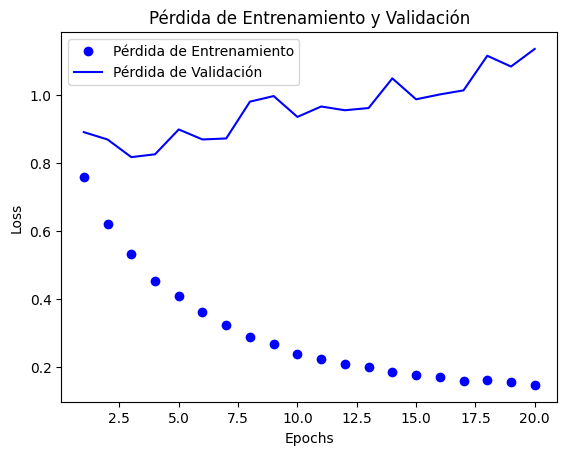

In [ ]:
pinta_perdida_entrenamiento_validacion(hist0)

Con 20 épocas hemos logrado mejorar bastante la precisión llegando al 80,7%. Este valor es notablemente superior a lo obtenido pero tampoco es la precisión deseada.

Finalmente, probemos 25 épocas.

In [12]:
hist4 = model.fit(train_data_padded,train_labels, validation_data=(val_data_padded, val_labels),epochs=25, callbacks=callbacks)
print(f"Test acc: {model.evaluate(test_data_padded,test_labels)[1]:.3f}")

Epoch 1/25
225/225 [==============================] - 171s 735ms/step - loss: 2.2057 - accuracy: 0.5166 - val_loss: 1.3662 - val_accuracy: 0.6978
Epoch 2/25
225/225 [==============================] - 172s 766ms/step - loss: 1.3302 - accuracy: 0.7031 - val_loss: 1.1236 - val_accuracy: 0.7390
Epoch 3/25
225/225 [==============================] - 172s 767ms/step - loss: 1.0033 - accuracy: 0.7688 - val_loss: 0.9662 - val_accuracy: 0.7863
Epoch 4/25
225/225 [==============================] - 172s 767ms/step - loss: 0.8058 - accuracy: 0.8117 - val_loss: 0.9199 - val_accuracy: 0.7735
Epoch 5/25
225/225 [==============================] - 172s 767ms/step - loss: 0.6435 - accuracy: 0.8461 - val_loss: 0.8095 - val_accuracy: 0.8119
Epoch 6/25
225/225 [==============================] - 172s 765ms/step - loss: 0.5592 - accuracy: 0.8644 - val_loss: 0.8316 - val_accuracy: 0.8180
Epoch 7/25
225/225 [==============================] - 172s 765ms/step - loss: 0.4701 - accuracy: 0.8841 - val_loss: 0.9648 -

Se puede observar que la precisión es del 80,3% por lo que ya no mejoramos el modelo.

Esto último se puede explicar atendiendo a la siguiente relación:


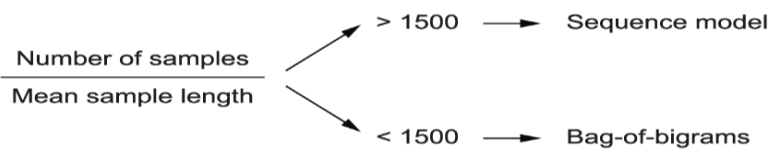


En este caso, el número de muestras es de 11.228 y el número medio de palabras por muestra es 145,5398574927633. Por tanto, se tiene una relación de 77,14725157. Al ser menor que 1.500 funcionará mucho mejor con bolsa de bigramas y será más rápido de entrenar.